In [1]:
#loading the packages
import pandas as pd
import json
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import spacy
from collections import Counter
import re
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import time
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')
from sklearn import svm
from xgboost import XGBClassifier
from keras import regularizers
from keras.layers import Embedding
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Flatten, Dense, Dropout,SpatialDropout1D, Activation
from keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils

In [44]:
#loading the data preprocessed accounting for linguistic nuances
train_df=pd.read_excel('train_df_clean.xlsx')

In [45]:
#loading development datasets and concatenating them
dev_de = pd.read_json("dataset_de_dev.json", lines=True)
dev_es = pd.read_json("dataset_es_dev.json", lines=True)
dev_en = pd.read_json("dataset_en_dev.json", lines=True)
dev_fr = pd.read_json("dataset_fr_dev.json", lines=True)
dev= pd.concat([dev_fr, dev_es, dev_de, dev_en], axis=0)
dev.reset_index(drop=True, inplace=True)
dev

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,fr_0112905,product_fr_0620743,reviewer_fr_0310864,1,Colis bien reçus avec le boîtier du jeu ouvert...,Commandé ailleurs si vous voulez des colis com...,fr,video_games
1,fr_0345365,product_fr_0942745,reviewer_fr_0244013,1,"Suite à une vérification, je vous informe que ...",COMMANDE NON RECUE,fr,office_product
2,fr_0474170,product_fr_0183830,reviewer_fr_0816879,1,"C'est un produit de piètre qualité sur quatre,...",Plastique sans aucune résistance !,fr,automotive
3,fr_0084156,product_fr_0195761,reviewer_fr_0933238,1,N'ont pas résistés. Piètre qualité,séparateur d'orteils,fr,sports
4,fr_0893613,product_fr_0077995,reviewer_fr_0492122,1,"Filament de qualité mais pas bien embobiné, ré...","ça coince, ça coince... que des problemes",fr,industrial_supplies
...,...,...,...,...,...,...,...,...
19995,en_0447642,product_en_0068982,reviewer_en_0061521,5,This ribbon is so adorable! Goes perfect with ...,So Cute!,en,home
19996,en_0950370,product_en_0563046,reviewer_en_0871798,5,I am in love with this kettle.,Perfect,en,kitchen
19997,en_0203466,product_en_0848682,reviewer_en_0474236,5,My Doberman Loves Having His Nails Trimmed and...,My Doberman Loves Them,en,pet_products
19998,en_0010627,product_en_0536493,reviewer_en_0546192,5,"I love my Fire.. I do everything on it, read, ...",Five Stars,en,other


In [47]:
#loading the test data set
test=pd.read_excel('test.xlsx')

In [46]:
#resetting the index for the data frame
train_df.reset_index(drop=True, inplace=True)

In [48]:
#one-hot encoding the target variable
label_encoder = preprocessing.LabelEncoder()
labels = label_encoder.fit_transform(train_df.language.values)
labels1=label_encoder.fit_transform(test.language.values)
labels3=label_encoder.fit_transform(dev.language.values)
np.unique(labels3)

array([0, 1, 2, 3])

In [49]:
#setting the test, train and val values
X_train=train_df.new
X_test=test.review_body
X_val=dev.review_body
y_train=labels
y_test=labels1
y_val=labels3

In [50]:
#setting the maximum size and maximum length
VOCABULARY_SIZE = 1000000
MAX_LENGTH = 200

In [51]:
#tokenizing
tokenizer = Tokenizer(num_words=VOCABULARY_SIZE)
tokenizer.fit_on_texts(list(X_train) + list(X_test)+ list(X_val))

xtrain_sequence = tokenizer.texts_to_sequences(X_train)
xtest_sequence = tokenizer.texts_to_sequences(X_test)
xval_sequence = tokenizer.texts_to_sequences(X_val)

In [52]:
#padding
xtrain_padding = pad_sequences(xtrain_sequence, maxlen=MAX_LENGTH)
xtest_padding = pad_sequences(xtest_sequence, maxlen=MAX_LENGTH)
xval_padding = pad_sequences(xval_sequence, maxlen=MAX_LENGTH)
#word_index = tokenizer.word_index

In [53]:
#creating a matrix
ytrain_encode = np_utils.to_categorical(y_train)
ytest_encode = np_utils.to_categorical(y_test)
yval_encode = np_utils.to_categorical(y_val)

In [12]:
# creating abidirectional LSTM model
model_st_m = Sequential()
#embedding layer
model_st_m.add(Embedding(1000000,8,input_length=MAX_LENGTH))
model_st_m.add(Bidirectional(LSTM(100)))
model_st_m.add(Dense(4))
model_st_m.add(Activation('softmax'))
model_st_m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
history_st_m = model_st_m.fit(xtrain_padding, y=ytrain_encode, batch_size=4000, epochs=12, verbose=1, validation_data=(xval_padding, yval_encode))


Epoch 1/12
185/185 [==============================] - 1453s 8s/step - loss: 0.6370 - accuracy: 0.7651 - val_loss: 0.1425 - val_accuracy: 0.9586
Epoch 2/12
185/185 [==============================] - 1432s 8s/step - loss: 0.1631 - accuracy: 0.9657 - val_loss: 0.0386 - val_accuracy: 0.9947
Epoch 3/12
185/185 [==============================] - 1494s 8s/step - loss: 0.0233 - accuracy: 0.9972 - val_loss: 0.0159 - val_accuracy: 0.9978
Epoch 4/12
185/185 [==============================] - 1504s 8s/step - loss: 0.0130 - accuracy: 0.9983 - val_loss: 0.0118 - val_accuracy: 0.9978
Epoch 5/12
185/185 [==============================] - 1415s 8s/step - loss: 0.0074 - accuracy: 0.9991 - val_loss: 0.0070 - val_accuracy: 0.9990
Epoch 6/12
185/185 [==============================] - 1380s 7s/step - loss: 0.0047 - accuracy: 0.9995 - val_loss: 0.0052 - val_accuracy: 0.9992
Epoch 7/12
185/185 [==============================] - 1379s 7s/step - loss: 0.0033 - accuracy: 0.9997 - val_loss: 0.0041 - val_accuracy:

In [58]:
#using test set to compare against validation set and see if any overfitting occurs.
test_loss, test_acc = model_st_m.evaluate(xtest_padding, ytest_encode)
print('Test accuracy:', test_acc)

625/625 [==============================] - 16s 26ms/step - loss: 0.0089 - accuracy: 0.9994
Test accuracy: 0.9993500113487244


In [56]:
y_pred=model_st_m.predict(xtest_padding)
y_pred =(y_pred>0.5)

In [59]:
training_loss = history_st_m.history['loss']
test_loss = history_st_m.history['val_loss']

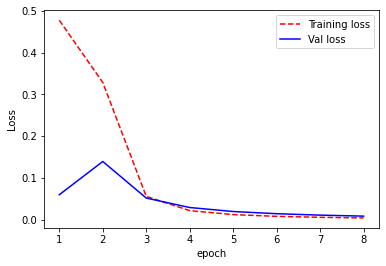

In [60]:
import matplotlib.pyplot as plt
#plotting the loss
epoch_count = range(1,len(training_loss) +1)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss,'b-')
plt.legend(['Training loss', 'Val loss'])
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show();

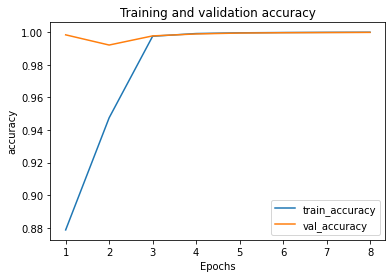

In [61]:
#plotting the accuracy
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
plot_metric(history_st_m, 'accuracy')

In [63]:
#loading long Europarl sample
formal_large=pd.read_excel('formal_large.xlsx')

In [ ]:
#Europarl truncated
formal_short_nostop=pd.read_excel('formal_nostop.xlsx')
formal_short_nostop.head()

In [65]:
#loading short TED Talks sample
functional=pd.read_excel('functional_words.xlsx')
functional=functional[functional['text'].str.split().str.len().ge(2)]
functional= functional[functional['text'].notnull()]

functional.reset_index(drop=True, inplace=True)

In [66]:
#loading long TED Talks sample
ted_talk_full=pd.read_excel('tedtalk_full_large.xlsx')
ted_talk_full=ted_talk_full[ted_talk_full['text'].str.split().str.len().ge(4)]
ted_talk_full= ted_talk_full[ted_talk_full['text'].notnull()]
ted_talk_full.reset_index(drop=True, inplace=True)

In [67]:
#accuracy for long formal sample Europarl
from sklearn import metrics
tokenizer.fit_on_texts(formal_large.txt)
tokens_sequence = tokenizer.texts_to_sequences(formal_large.txt)
tokens_padding = pad_sequences(tokens_sequence, maxlen=200)
y_predict_new = (model_st_m.predict(tokens_padding)>0.5).astype('int32')
#y_predict =(y_pred>0.5)
y_predict_new=np.argmax(y_predict_new,1)
langs=label_encoder.inverse_transform(y_predict_new)
first_tuple_elements = []
for lang in langs:
    first_tuple_elements.append(lang)
score3=metrics.accuracy_score(formal_large.lang,first_tuple_elements)

In [68]:
score3

0.31353311023222796

In [70]:
#accuracy for short formal sample Europarl
from sklearn import metrics
tokenizer.fit_on_texts(formal_short_nostop.txt)
tokens_sequence = tokenizer.texts_to_sequences(formal_short_nostop.txt)
tokens_padding = pad_sequences(tokens_sequence, maxlen=200)
y_predict_new = (model_st_m.predict(tokens_padding)>0.5).astype('int32')
#y_predict =(y_pred>0.5)
y_predict_new=np.argmax(y_predict_new,1)
langs=label_encoder.inverse_transform(y_predict_new)
first_tuple_elements = []
for lang in langs:
    first_tuple_elements.append(lang)
score3=metrics.accuracy_score(formal_short_nostop.lang,first_tuple_elements)

In [71]:
score3

0.2615254326999418

In [72]:
#accuracy for short TED Talks sample
from sklearn import metrics
tokenizer.fit_on_texts(functional.text)
tokens_sequence = tokenizer.texts_to_sequences(functional.text)
tokens_padding = pad_sequences(tokens_sequence, maxlen=MAX_LENGTH)
y_predict_new = (model_st_m.predict(tokens_padding)>0.5).astype('int32')
#y_predict =(y_pred>0.5)
y_predict_new=np.argmax(y_predict_new,1)
langs=label_encoder.inverse_transform(y_predict_new)
score5=metrics.accuracy_score(functional.lang,langs)

In [73]:
score5

0.2863102974138743

In [74]:
#Accuracy for long TED Talks sample
tokenizer.fit_on_texts(ted_talk_full.text)
tokens_sequence = tokenizer.texts_to_sequences(ted_talk_full.text)
tokens_padding = pad_sequences(tokens_sequence, maxlen=MAX_LENGTH)
y_predict_new = (model_st_m.predict(tokens_padding)>0.3).astype('int32')
#y_predict =(y_pred>0.5)
y_predict_new=np.argmax(y_predict_new,1)
langs=label_encoder.inverse_transform(y_predict_new)
score6=metrics.accuracy_score(ted_talk_full.lang,langs)
#y_new=model_s.predict_classes(tokens_padding)

In [75]:
score6

0.29752651884307774